In [1]:
import pandas as pd
import numpy as np
totalled_df = pd.DataFrame.from_csv('totalled_df.csv') # all data

**CHANGE BTC PRICE TO UP/DOWN**

In [2]:
# FOR ALL DATA, EXCLUDING MEMPOOL
data_df = totalled_df.copy(deep=True)
prev_price = 0
for i, row in data_df.iterrows():
    change = 0
    if row[0] > prev_price:
        change = 1
    prev_price = row[0]
    data_df.set_value(i-86400,'y', change)

data_df = data_df.iloc[:-2,:] # remove last two (one NAN row created and one that doesn't have a future date)
data_df = data_df.drop('mempool-count', 1)

NaN_by_column = data_df.isnull().sum(axis=0).tolist()
print(NaN_by_column) # trade volue is the only feature missing data

[0, 15, 0, 0, 0, 0, 0, 0, 0]


In [3]:
# FIX MISSING DATA
trade_volume_mean = np.mean(data_df['trade-volume'])
data_df = data_df.fillna(trade_volume_mean) # replace the 15 NaN with mean

NaN_by_column = data_df.isnull().sum(axis=0).tolist()
print(NaN_by_column) # no missing data now

data_df.head()
# data_df.shape

[0, 0, 0, 0, 0, 0, 0, 0, 0]


,market-price,trade-volume,median-confirmation-time,hash-rate,transaction-fees-usd,n-unique-addresses,n-transactions,n-transactions-excluding-popular,y
x,,,,,,,,,
1333238400,4.92,182041.75,8.74,12.12,21.40,9586.0,5619.0,4221.0,1.0
1333324800,5.08,429855.97,11.46,10.26,21.03,10766.0,6086.0,4676.0,0.0
1333411200,5.00,394194.22,10.03,10.34,23.17,13073.0,7539.0,5962.0,0.0
1333497600,4.96,281521.13,10.15,11.40,19.64,12774.0,7479.0,5980.0,0.0
1333584000,4.94,187559.84,10.27,9.62,30.71,11946.0,6977.0,5552.0,1.0


In [4]:
# CREATE FEATURE ARRAY
feature_dict = {0: 'market-price', 1: 'trade-volume', 2: 'median-confirmation-time', 3: 'hash-rate', 4: 'transaction-fees-usd', 
     5: 'n-unique-addresses', 6: 'n-transactions', 7: 'n-transactions-excluding-popular'}

features = []
for k in feature_dict:
    features.append(data_df[feature_dict[k]].values)

***EXPLORE DIFFERENT DATA TRANSFORMATIONS***

In [5]:
# taken from: https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/

from statsmodels.tsa.stattools import adfuller
# import matplotlib.pylab as plt
from matplotlib import pyplot

# used for nice comparisons:
market_price_comparison = np.log(features[0])

# if plotPrice also plot the log market price, if showDFT also perform the Dicky-Fuller test
def test_stationarity(timeseries, feature_name, plotPrice=False, showDFT=True):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=28)
    rolstd = pd.rolling_std(timeseries, window=28)

    #Plot rolling statistics:
    pyplot.figure(figsize=(12, 4), dpi=120)
    if plotPrice:
        pyplot.plot(market_price_comparison, color='green',label='BTC price') # COMPARISON NB
    orig = pyplot.plot(timeseries, color='blue',label='Original')
    mean = pyplot.plot(rolmean, color='red', label='Rolling Mean')
    std = pyplot.plot(rolstd, color='black', label = 'Rolling Std')
    pyplot.legend(loc='best')
    pyplot.title(feature_name + ': Rolling Mean & Standard Deviation')
    pyplot.show(block=False)
    
    if showDFT:
        #Perform Dickey-Fuller test:
        print ('Results of Dickey-Fuller Test:')
        dftest = adfuller(timeseries, autolag='AIC')
        dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
        for key,value in dftest[4].items():
            dfoutput['Critical Value (%s)' % key] = value
        print (dfoutput)

C:\Users\user\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
  from ipykernel import kernelapp as app


market-price


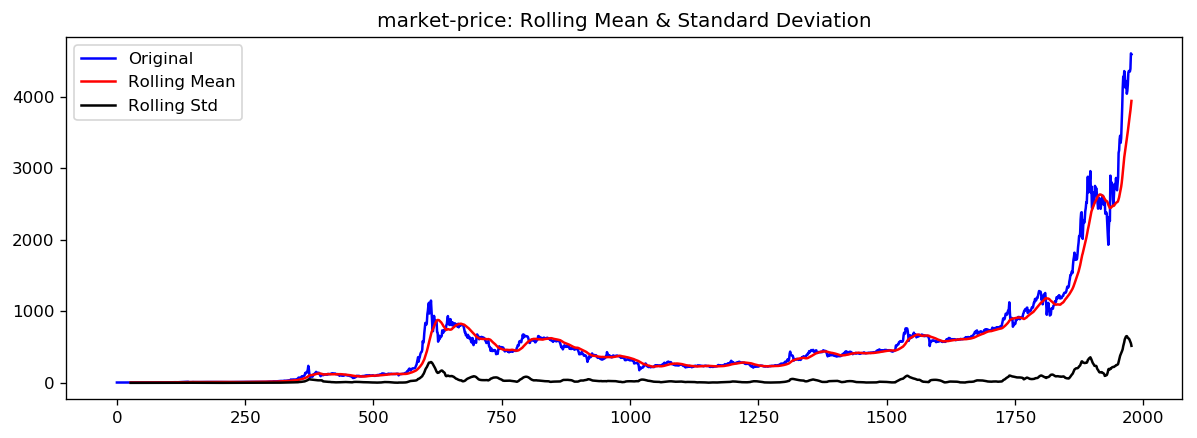

Results of Dickey-Fuller Test:
Test Statistic                    3.888739
p-value                           1.000000
#Lags Used                       21.000000
Number of Observations Used    1956.000000
Critical Value (1%)              -3.433698
Critical Value (5%)              -2.863019
Critical Value (10%)             -2.567557
dtype: float64



trade-volume


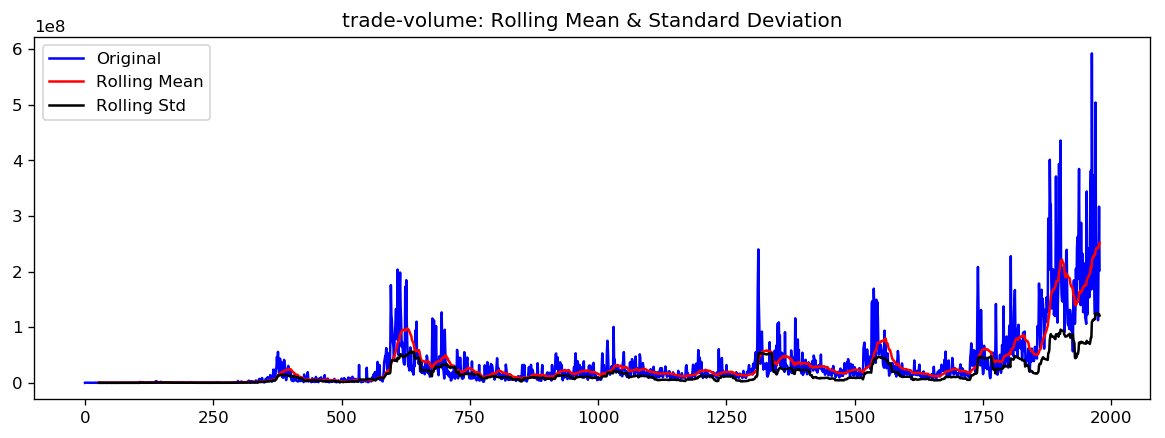

Results of Dickey-Fuller Test:
Test Statistic                   -0.440389
p-value                           0.903134
#Lags Used                       24.000000
Number of Observations Used    1953.000000
Critical Value (1%)              -3.433703
Critical Value (5%)              -2.863021
Critical Value (10%)             -2.567558
dtype: float64



median-confirmation-time


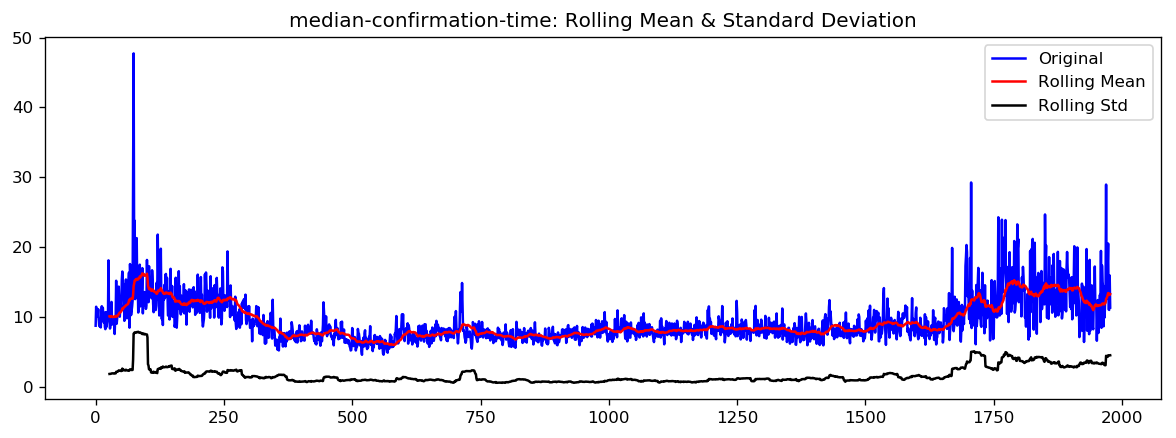

Results of Dickey-Fuller Test:
Test Statistic                   -1.729315
p-value                           0.416075
#Lags Used                       26.000000
Number of Observations Used    1951.000000
Critical Value (1%)              -3.433706
Critical Value (5%)              -2.863023
Critical Value (10%)             -2.567559
dtype: float64



hash-rate


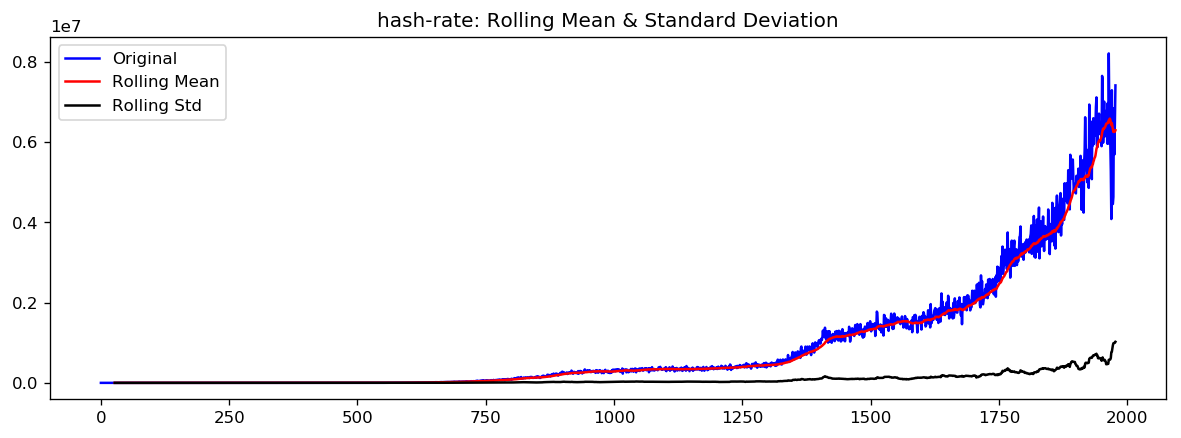

Results of Dickey-Fuller Test:
Test Statistic                    4.586073
p-value                           1.000000
#Lags Used                       25.000000
Number of Observations Used    1952.000000
Critical Value (1%)              -3.433704
Critical Value (5%)              -2.863022
Critical Value (10%)             -2.567559
dtype: float64



transaction-fees-usd


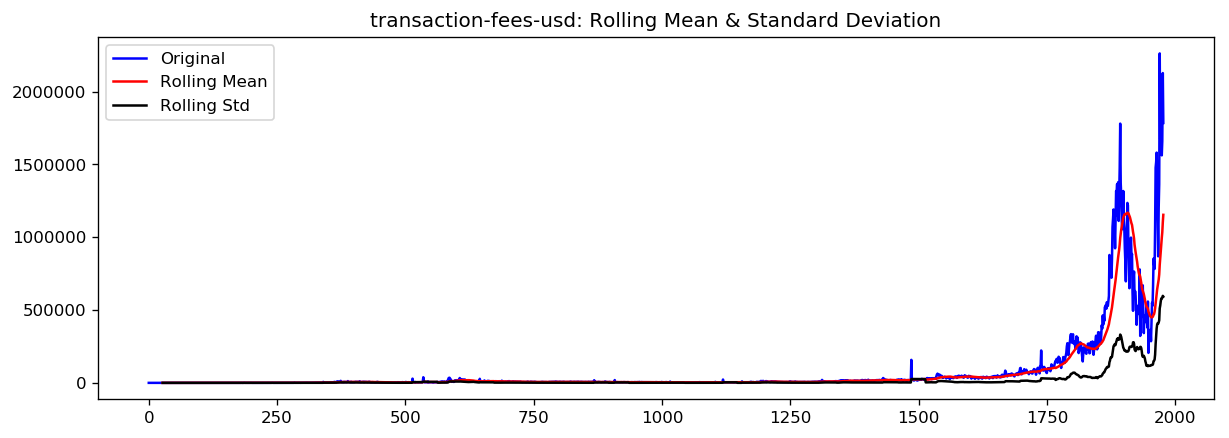

Results of Dickey-Fuller Test:
Test Statistic                    0.135832
p-value                           0.968424
#Lags Used                       25.000000
Number of Observations Used    1952.000000
Critical Value (1%)              -3.433704
Critical Value (5%)              -2.863022
Critical Value (10%)             -2.567559
dtype: float64



n-unique-addresses


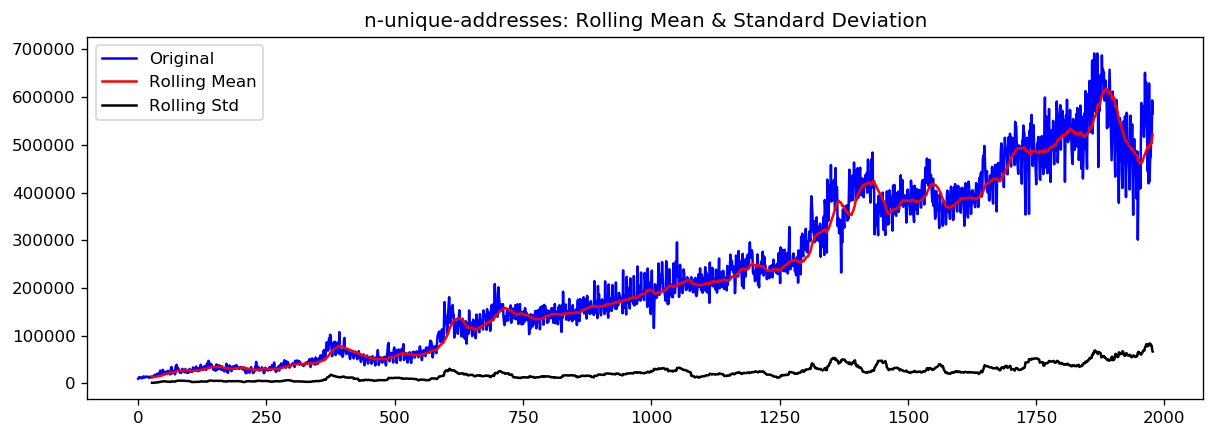

Results of Dickey-Fuller Test:
Test Statistic                   -0.190116
p-value                           0.939690
#Lags Used                       26.000000
Number of Observations Used    1951.000000
Critical Value (1%)              -3.433706
Critical Value (5%)              -2.863023
Critical Value (10%)             -2.567559
dtype: float64



n-transactions


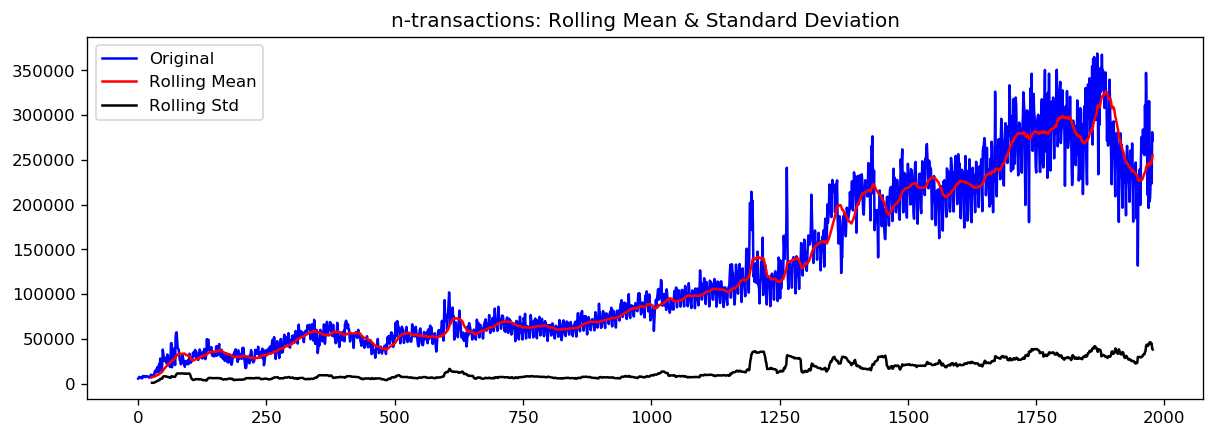

Results of Dickey-Fuller Test:
Test Statistic                   -0.727465
p-value                           0.839507
#Lags Used                       26.000000
Number of Observations Used    1951.000000
Critical Value (1%)              -3.433706
Critical Value (5%)              -2.863023
Critical Value (10%)             -2.567559
dtype: float64



n-transactions-excluding-popular


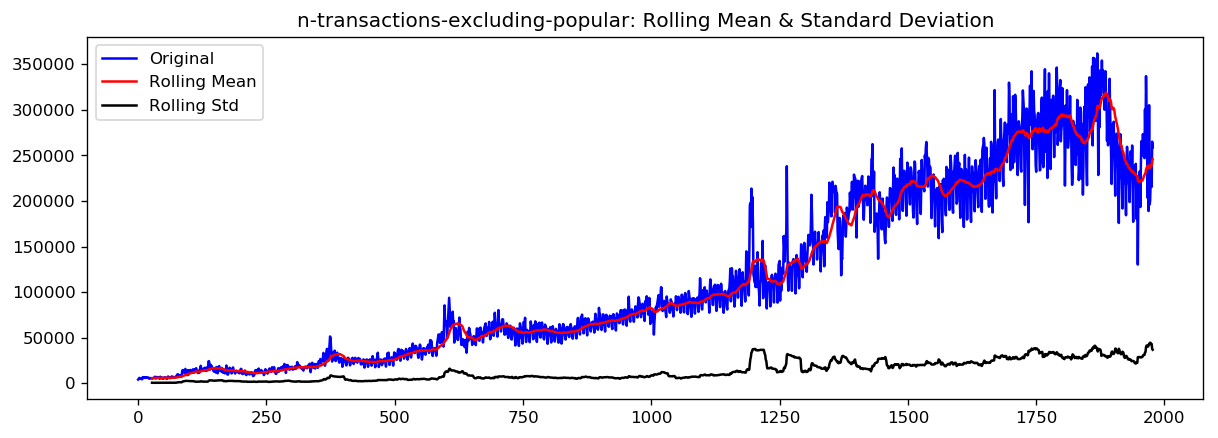

Results of Dickey-Fuller Test:
Test Statistic                   -0.615230
p-value                           0.867503
#Lags Used                       26.000000
Number of Observations Used    1951.000000
Critical Value (1%)              -3.433706
Critical Value (5%)              -2.863023
Critical Value (10%)             -2.567559
dtype: float64





In [6]:
# print stationary test for all features
for i in feature_dict:
    print(feature_dict[i])
    series = features[i]
    test_stationarity(series, feature_dict[i])
    print('\n\n')
    

In [7]:
# quick method for plotting a timeseries
def plot_series(series):
    pyplot.figure(figsize=(12, 4), dpi=120)
    pyplot.plot(series)
    pyplot.show()

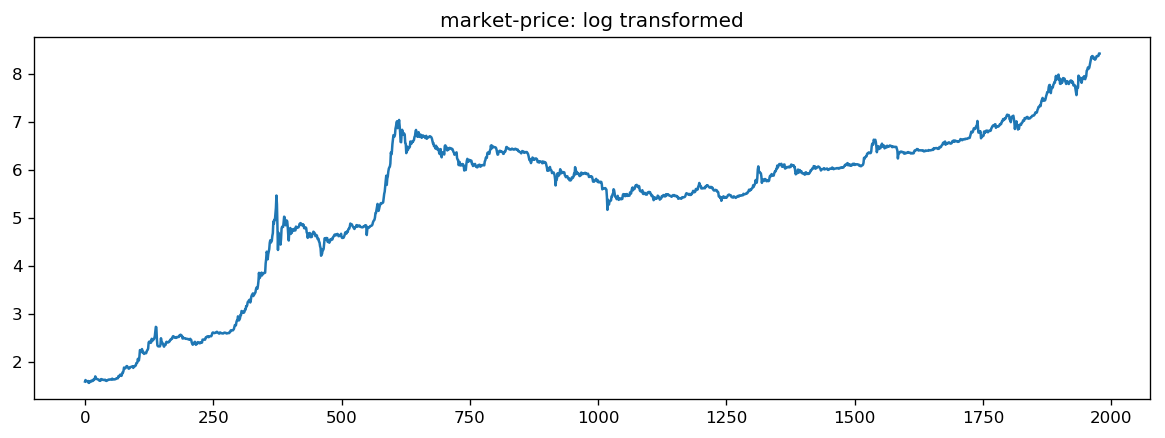

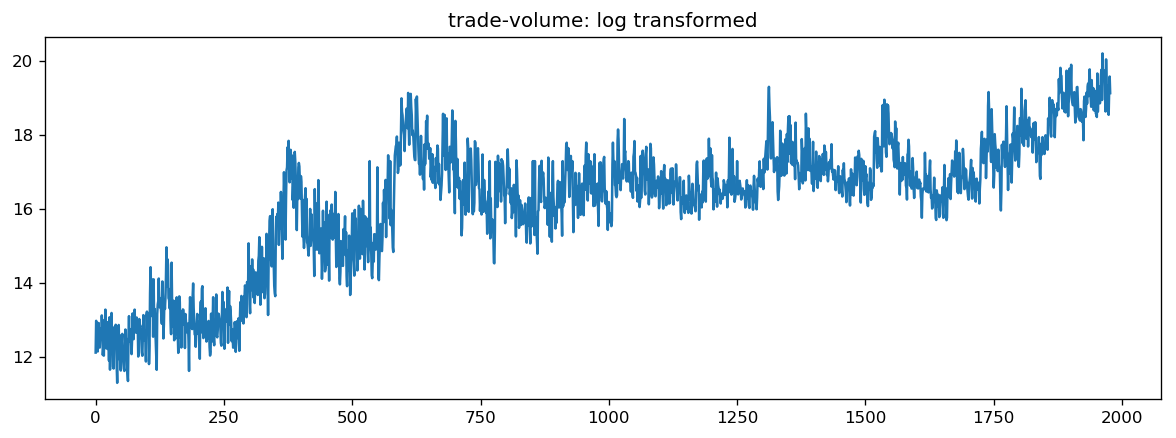

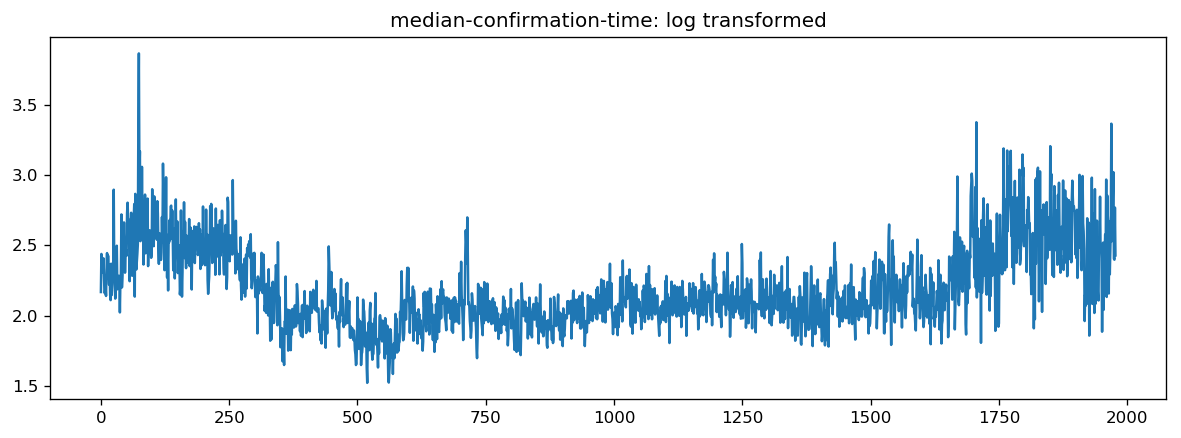

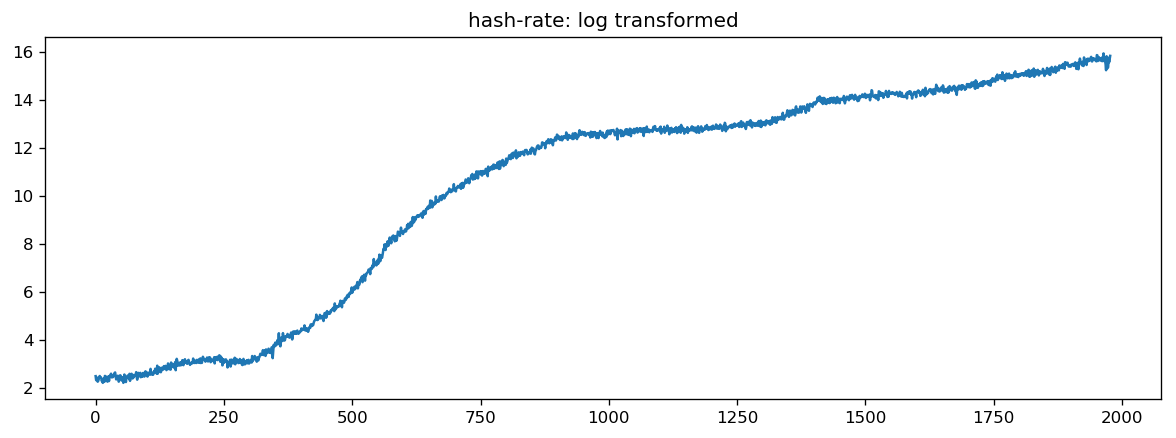

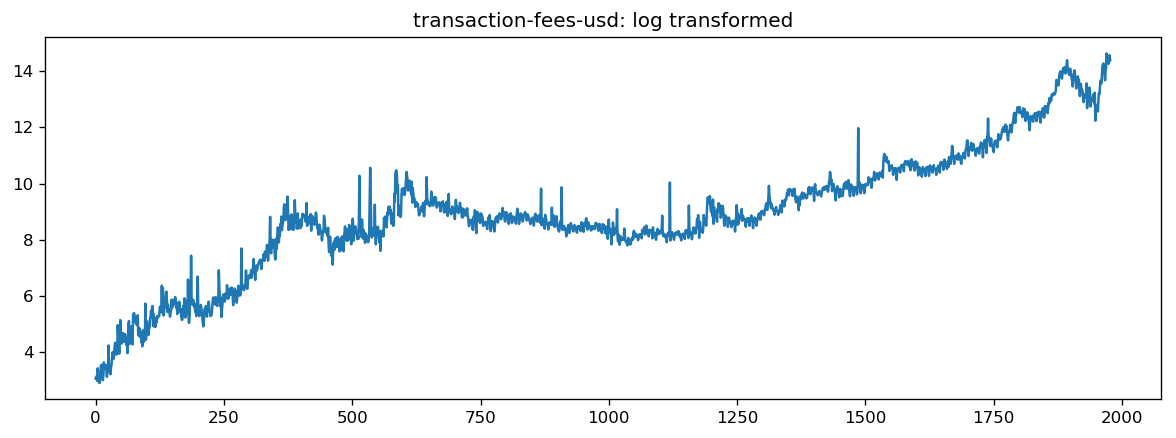

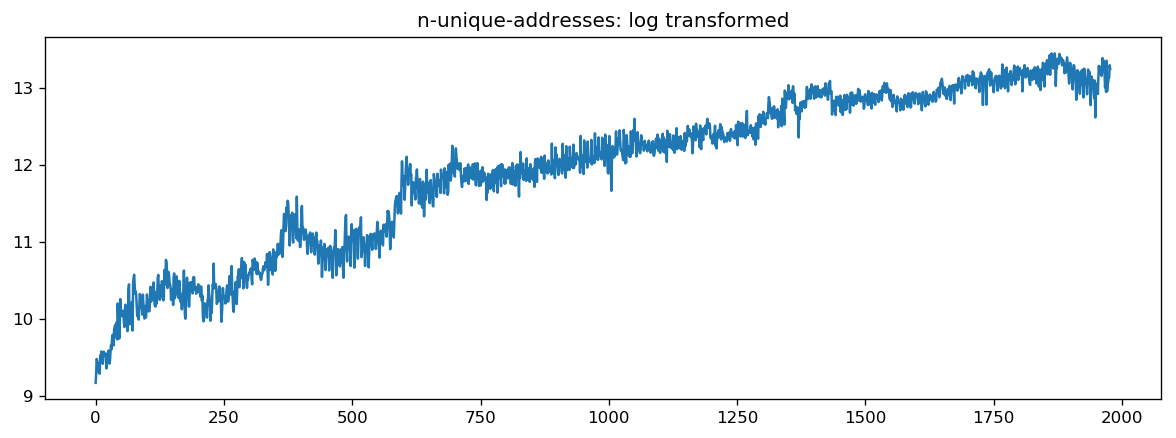

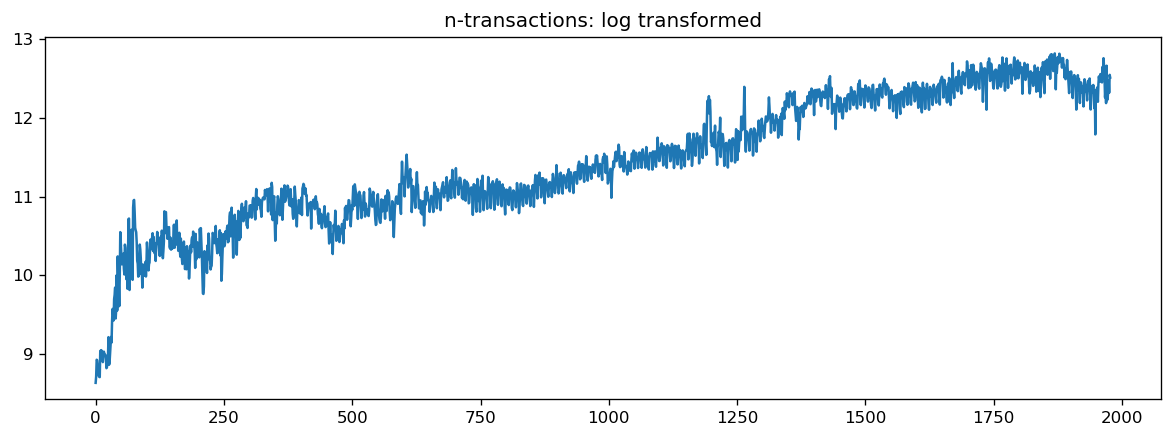

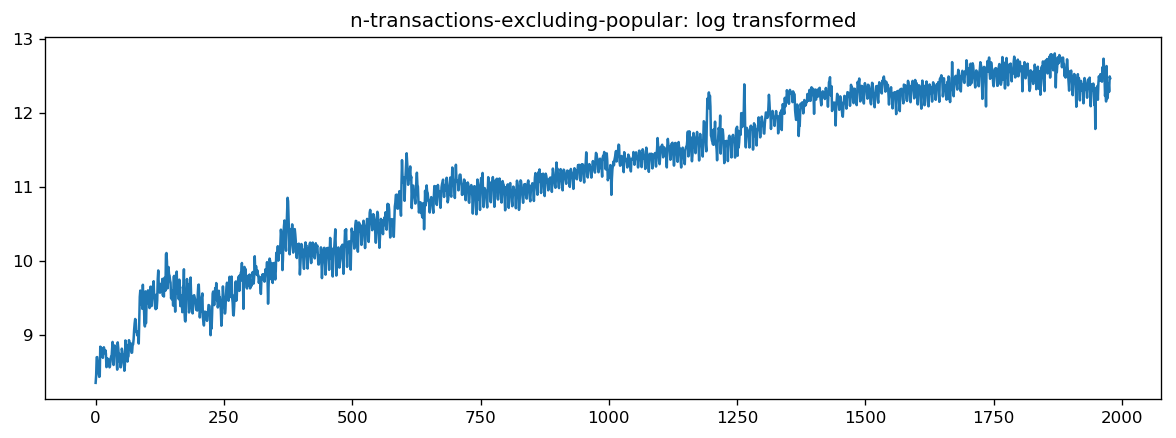

In [8]:
# now log-transform each data series
#     log is the natural choice when data is non euclidian !!

def transform_series_log(timeseries, feature_name):
    ts_log = np.log(timeseries)
    pyplot.figure(figsize=(12, 4), dpi=120)
    pyplot.title(feature_name + ": log transformed")
    pyplot.plot(ts_log)
    pyplot.show()
    return ts_log

# show log-transformed data for all features
for i in feature_dict:
    series = features[i]
    transform_series_log(series, feature_dict[i])
    print('\n\n')

In [9]:
# LOG TRANSFORM
market_prices = features[0]
ts_log = np.log(market_prices)

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  


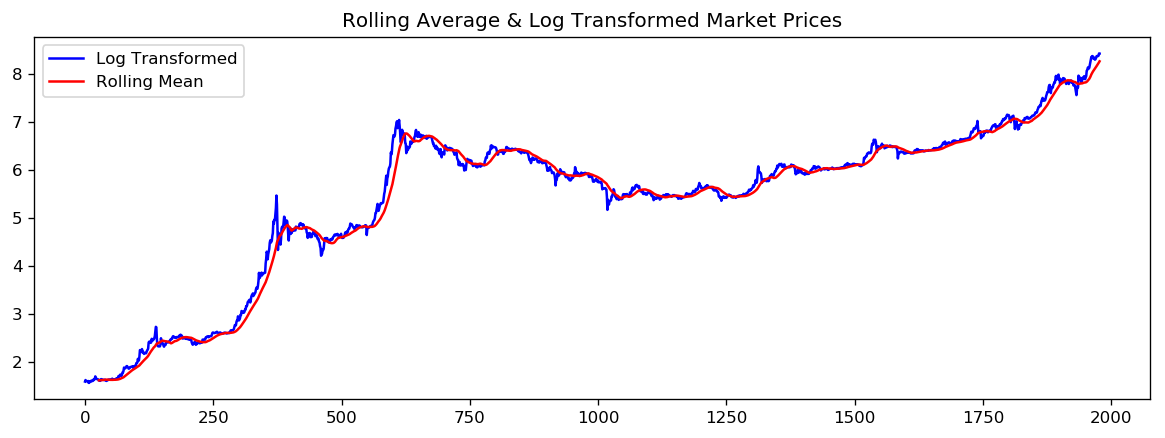

In [10]:
# rolling mean plot example
moving_avg = pd.rolling_mean(ts_log,28) # 4 week rolling average
pyplot.figure(figsize=(12, 4), dpi=120)
pyplot.title('Rolling Average & Log Transformed Market Prices')
pyplot.plot(ts_log, color='blue',label='Log Transformed')
pyplot.plot(moving_avg, color='red', label='Rolling Mean')
pyplot.legend(loc='best')
pyplot.show()

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
  from ipykernel import kernelapp as app


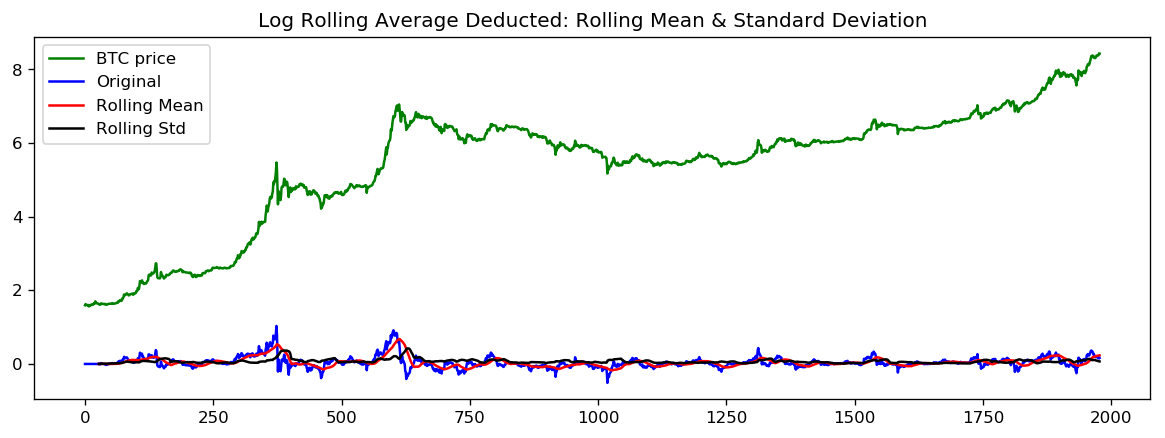

Results of Dickey-Fuller Test:
Test Statistic                   -5.510619
p-value                           0.000002
#Lags Used                       24.000000
Number of Observations Used    1953.000000
Critical Value (1%)              -3.433703
Critical Value (5%)              -2.863021
Critical Value (10%)             -2.567558
dtype: float64


In [11]:
# DATA TRANSFORM OPTION 1: remove rolling mean
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff = np.nan_to_num(ts_log_moving_avg_diff)
test_stationarity(ts_log_moving_avg_diff, 'Log Rolling Average Deducted', True)

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


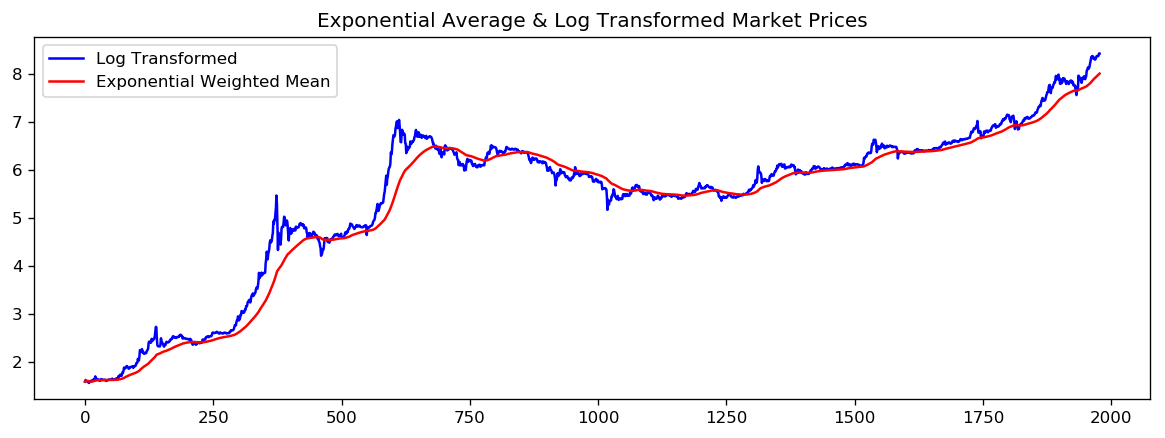

In [12]:
# exponentially weighted mean example 

expwighted_avg = pd.ewma(ts_log, halflife=28)
pyplot.figure(figsize=(12, 4), dpi=120)
pyplot.title('Exponential Average & Log Transformed Market Prices')
pyplot.plot(ts_log, color='blue',label='Log Transformed')
pyplot.plot(expwighted_avg, color='red', label='Exponential Weighted Mean')
pyplot.legend(loc='best')
pyplot.show()

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
  from ipykernel import kernelapp as app


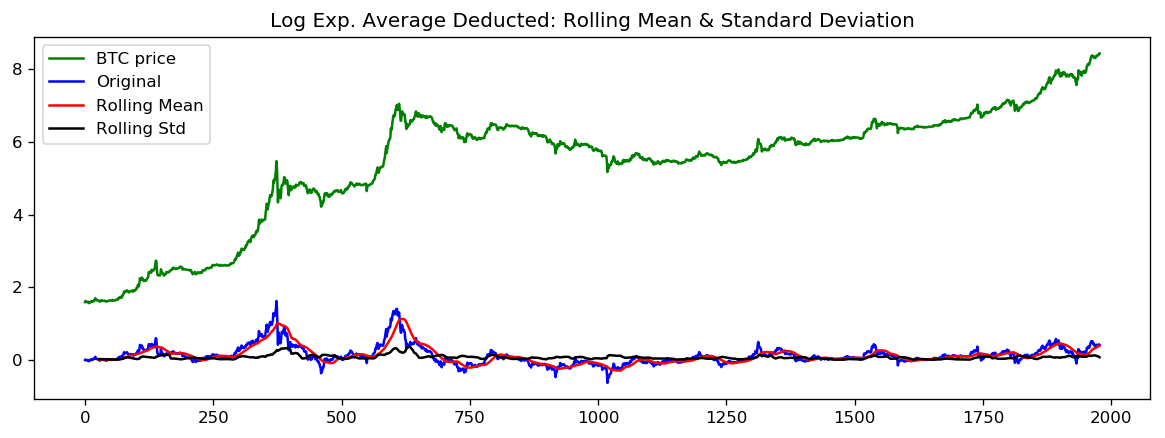

Results of Dickey-Fuller Test:
Test Statistic                   -3.764684
p-value                           0.003290
#Lags Used                       25.000000
Number of Observations Used    1952.000000
Critical Value (1%)              -3.433704
Critical Value (5%)              -2.863022
Critical Value (10%)             -2.567559
dtype: float64


In [13]:
# DATA TRANSFORM OPTION 2: remove exponentially weighted mean
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff, 'Log Exp. Average Deducted', True)

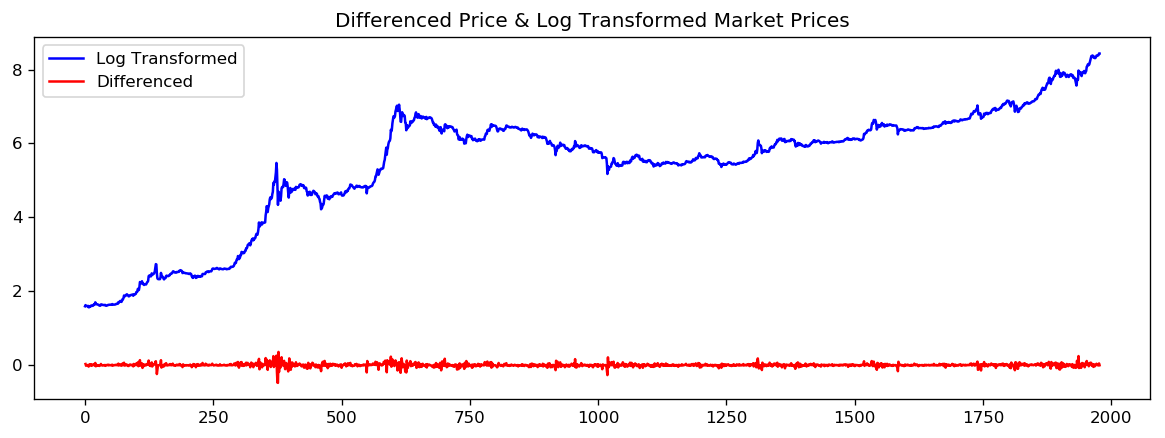

In [14]:
# differencing example 
from scipy.ndimage.interpolation import shift

ts_log_diff = ts_log - shift(ts_log, 1, cval=np.NaN)

pyplot.figure(figsize=(12, 4), dpi=120)
pyplot.title('Differenced Price & Log Transformed Market Prices')
pyplot.plot(ts_log, color='blue',label='Log Transformed')
pyplot.plot(ts_log_diff, color='red', label='Differenced')
pyplot.legend(loc='best')
pyplot.show()

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
  from ipykernel import kernelapp as app


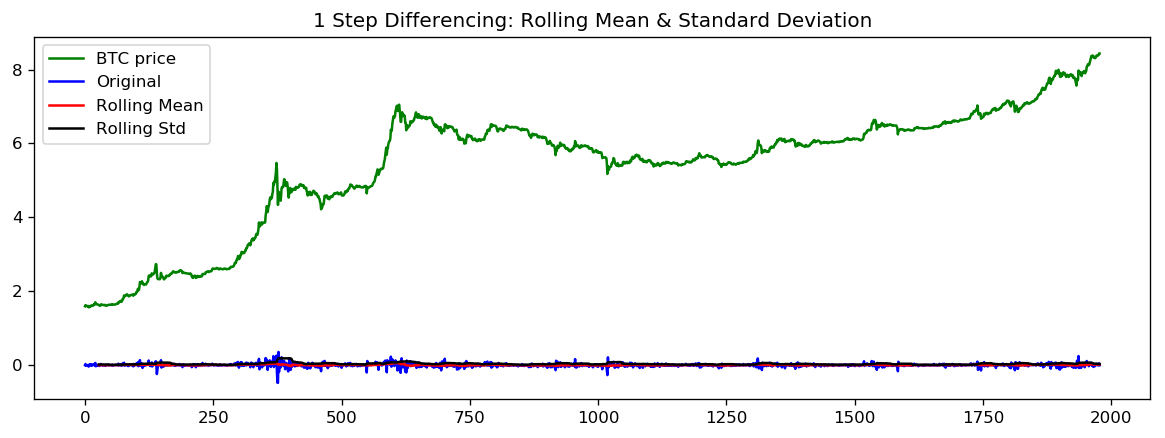

Results of Dickey-Fuller Test:
Test Statistic                -7.607798e+00
p-value                        2.297465e-11
#Lags Used                     2.400000e+01
Number of Observations Used    1.953000e+03
Critical Value (1%)           -3.433703e+00
Critical Value (5%)           -2.863021e+00
Critical Value (10%)          -2.567558e+00
dtype: float64


In [15]:
# DATA TRANSFORM OPTION 3: use differenced data

ts_log_diff = np.nan_to_num(ts_log_diff)
test_stationarity(ts_log_diff, '1 Step Differencing', True)

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
  from ipykernel import kernelapp as app


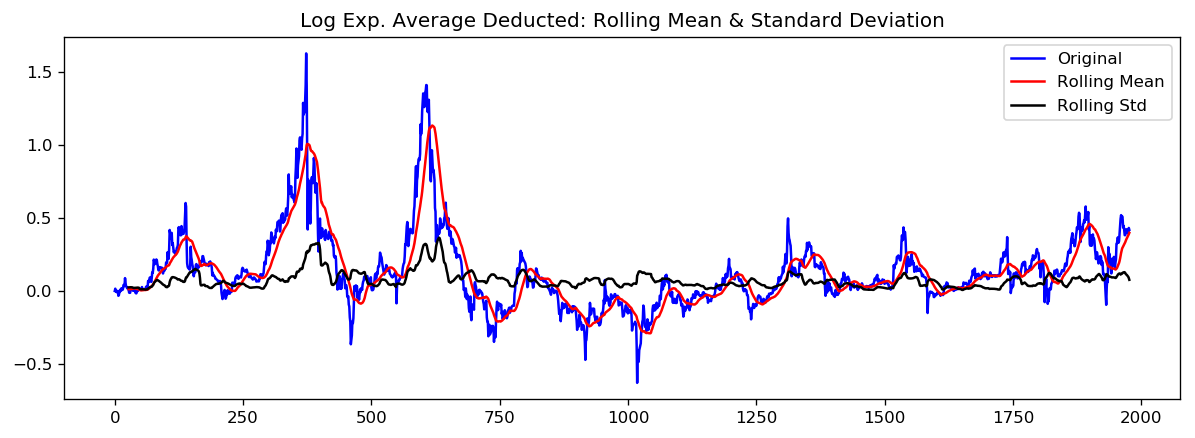

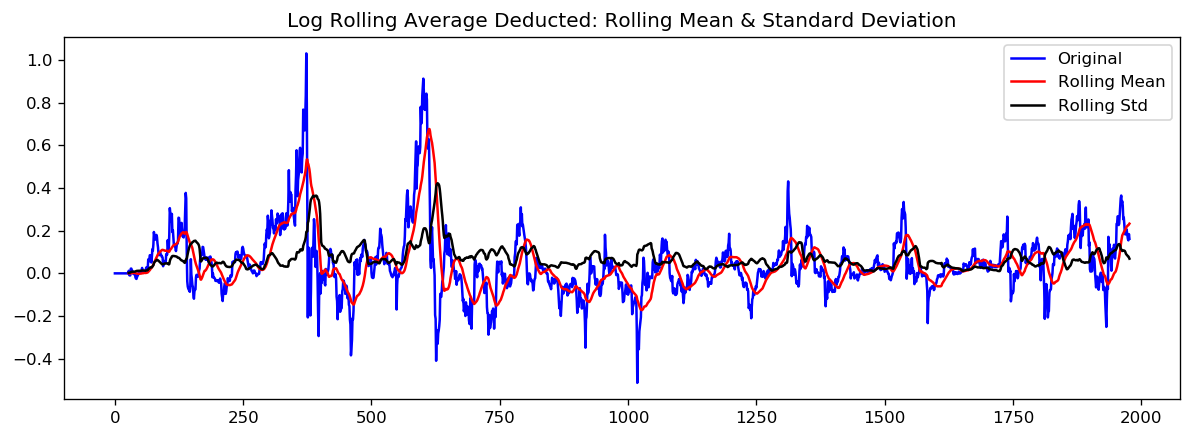

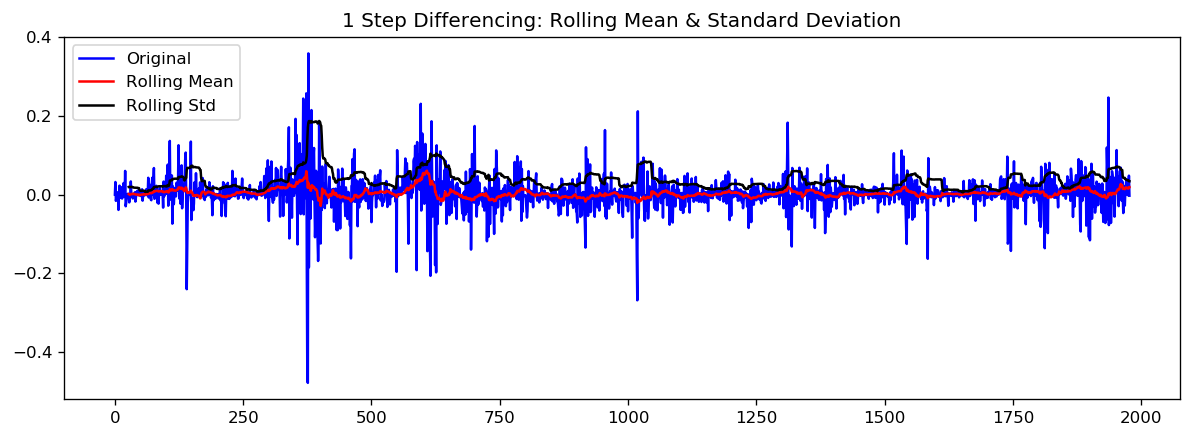

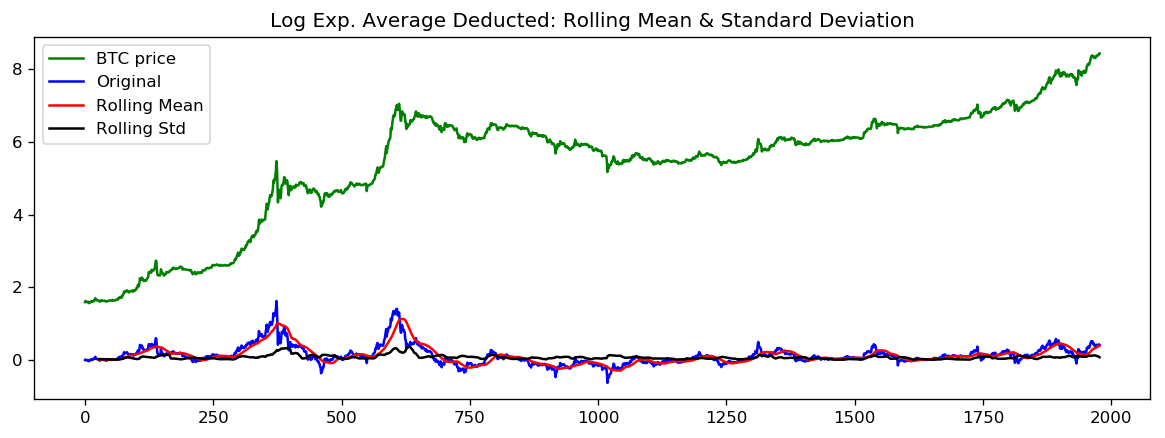

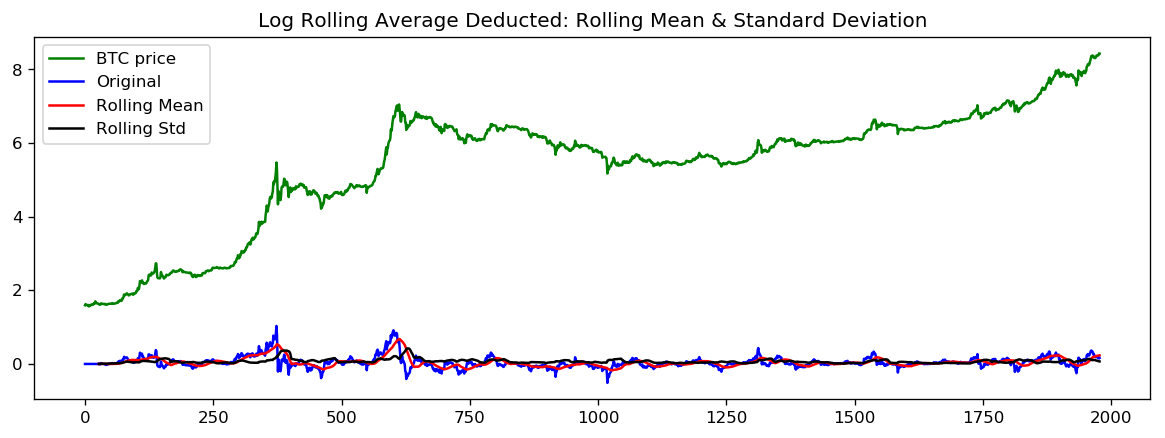

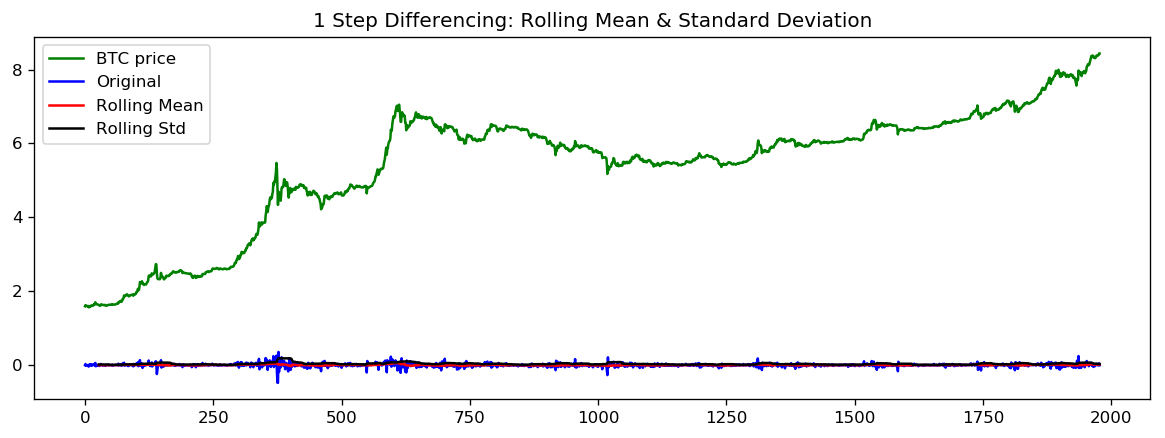

In [16]:
# COMPARISON OF ALL 3 DATA STAIONARISING APPROACHES:
test_stationarity(ts_log_ewma_diff, 'Log Exp. Average Deducted', False, False)
test_stationarity(ts_log_moving_avg_diff, 'Log Rolling Average Deducted', False, False)
test_stationarity(ts_log_diff, '1 Step Differencing', False, False)
# possibly train using all and see
test_stationarity(ts_log_ewma_diff, 'Log Exp. Average Deducted', True, False)
test_stationarity(ts_log_moving_avg_diff, 'Log Rolling Average Deducted', True, False)
test_stationarity(ts_log_diff, '1 Step Differencing', True, False)

***IMPLEMENT DATA TRANSFORMS ON ALL***

In [17]:
# we select exponentially weighted transform (OPTION 2) to use on all
def transform_series_log_expweighted(series):
    ts_log = np.log(series)
    expwighted_avg = pd.ewma(ts_log, halflife=28)
    ts_log_ewma_diff = ts_log - expwighted_avg
    return ts_log_ewma_diff

market-price


C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  after removing the cwd from sys.path.
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
  from ipykernel import kernelapp as app


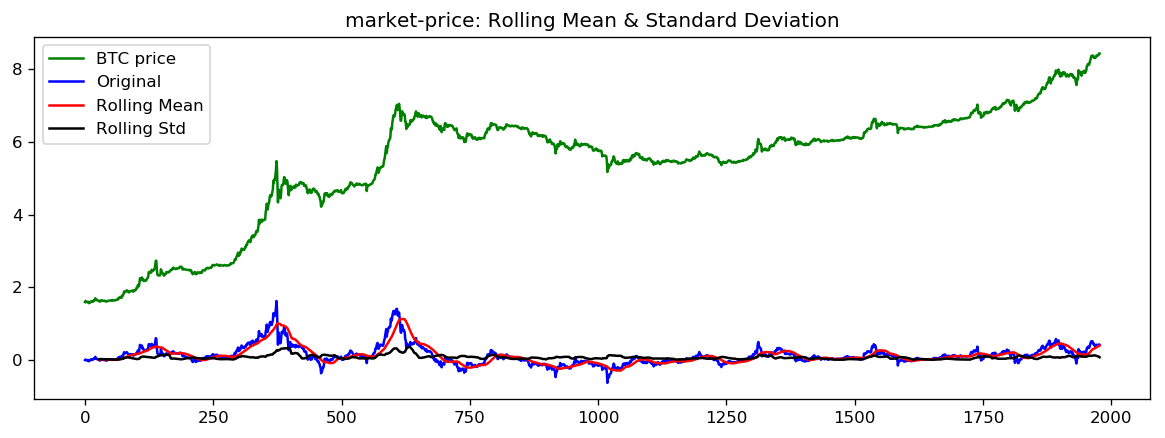

Results of Dickey-Fuller Test:
Test Statistic                   -3.764684
p-value                           0.003290
#Lags Used                       25.000000
Number of Observations Used    1952.000000
Critical Value (1%)              -3.433704
Critical Value (5%)              -2.863022
Critical Value (10%)             -2.567559
dtype: float64



trade-volume


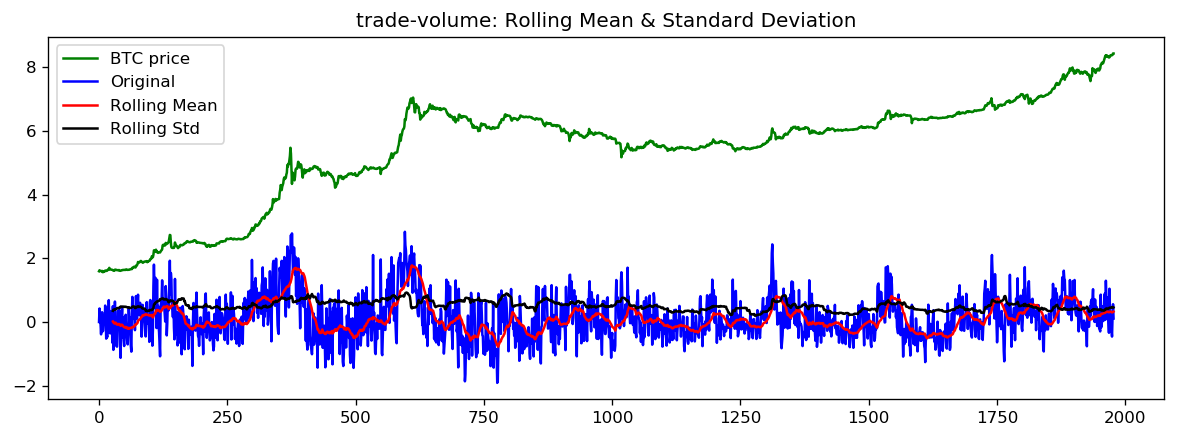

Results of Dickey-Fuller Test:
Test Statistic                -5.787794e+00
p-value                        4.952608e-07
#Lags Used                     2.200000e+01
Number of Observations Used    1.955000e+03
Critical Value (1%)           -3.433699e+00
Critical Value (5%)           -2.863020e+00
Critical Value (10%)          -2.567558e+00
dtype: float64



median-confirmation-time


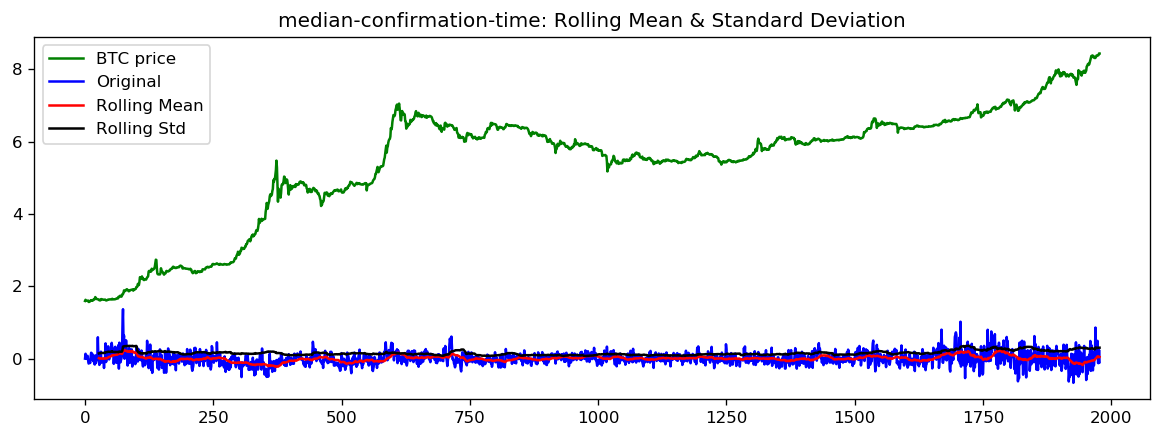

Results of Dickey-Fuller Test:
Test Statistic                -5.763068e+00
p-value                        5.613703e-07
#Lags Used                     2.400000e+01
Number of Observations Used    1.953000e+03
Critical Value (1%)           -3.433703e+00
Critical Value (5%)           -2.863021e+00
Critical Value (10%)          -2.567558e+00
dtype: float64



hash-rate


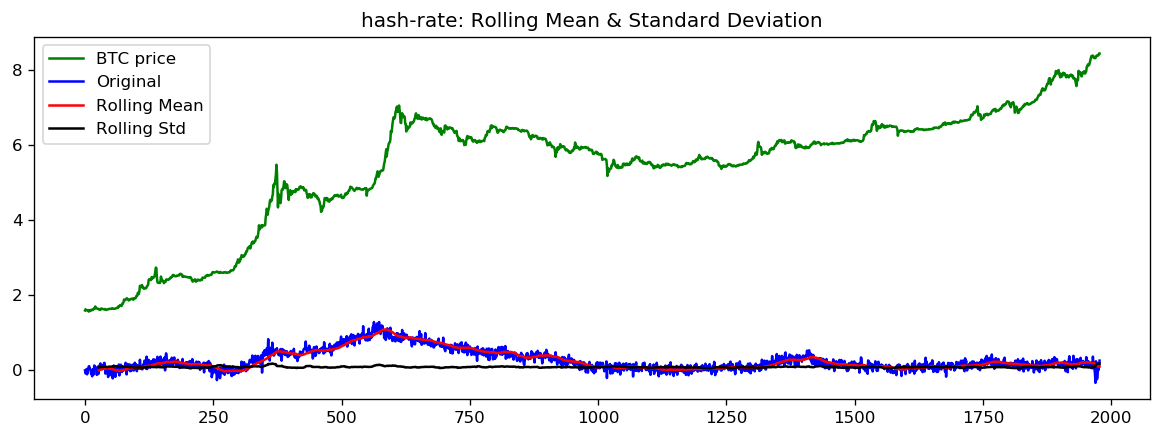

Results of Dickey-Fuller Test:
Test Statistic                   -1.563313
p-value                           0.501992
#Lags Used                       12.000000
Number of Observations Used    1965.000000
Critical Value (1%)              -3.433682
Critical Value (5%)              -2.863012
Critical Value (10%)             -2.567554
dtype: float64



transaction-fees-usd


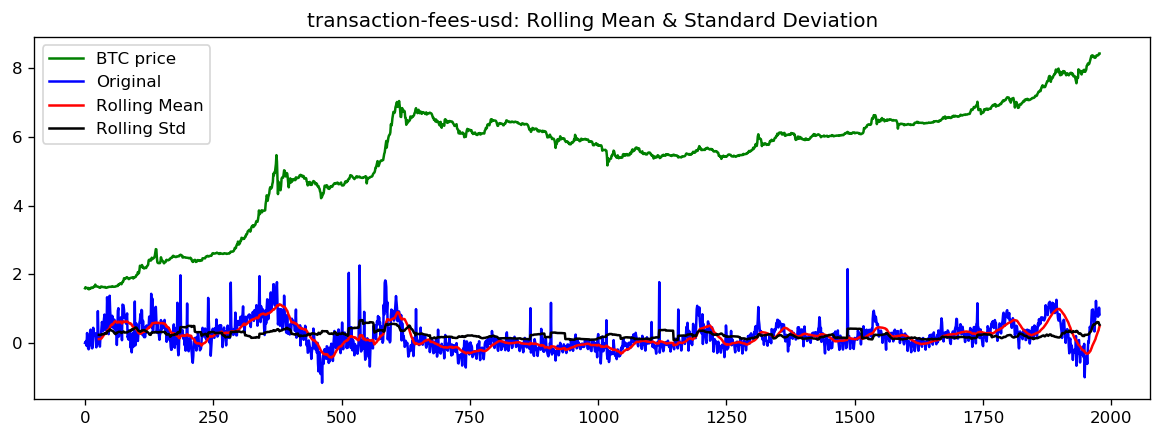

Results of Dickey-Fuller Test:
Test Statistic                   -4.491241
p-value                           0.000204
#Lags Used                       22.000000
Number of Observations Used    1955.000000
Critical Value (1%)              -3.433699
Critical Value (5%)              -2.863020
Critical Value (10%)             -2.567558
dtype: float64



n-unique-addresses


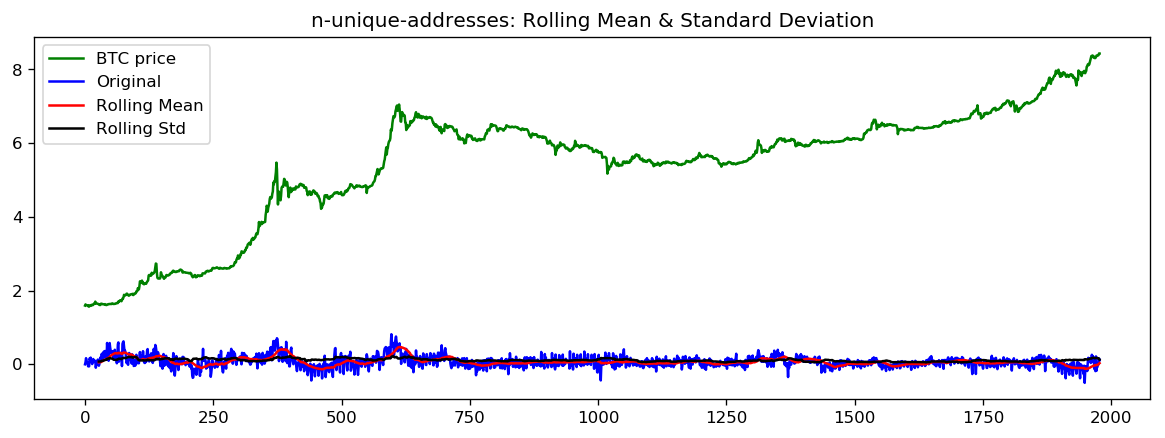

Results of Dickey-Fuller Test:
Test Statistic                   -5.380971
p-value                           0.000004
#Lags Used                       22.000000
Number of Observations Used    1955.000000
Critical Value (1%)              -3.433699
Critical Value (5%)              -2.863020
Critical Value (10%)             -2.567558
dtype: float64



n-transactions


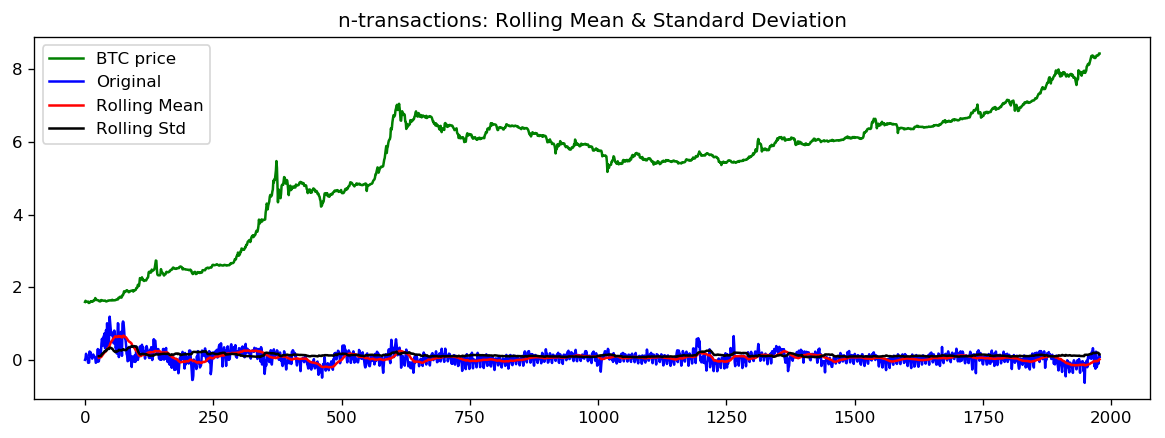

Results of Dickey-Fuller Test:
Test Statistic                   -4.974563
p-value                           0.000025
#Lags Used                       26.000000
Number of Observations Used    1951.000000
Critical Value (1%)              -3.433706
Critical Value (5%)              -2.863023
Critical Value (10%)             -2.567559
dtype: float64



n-transactions-excluding-popular


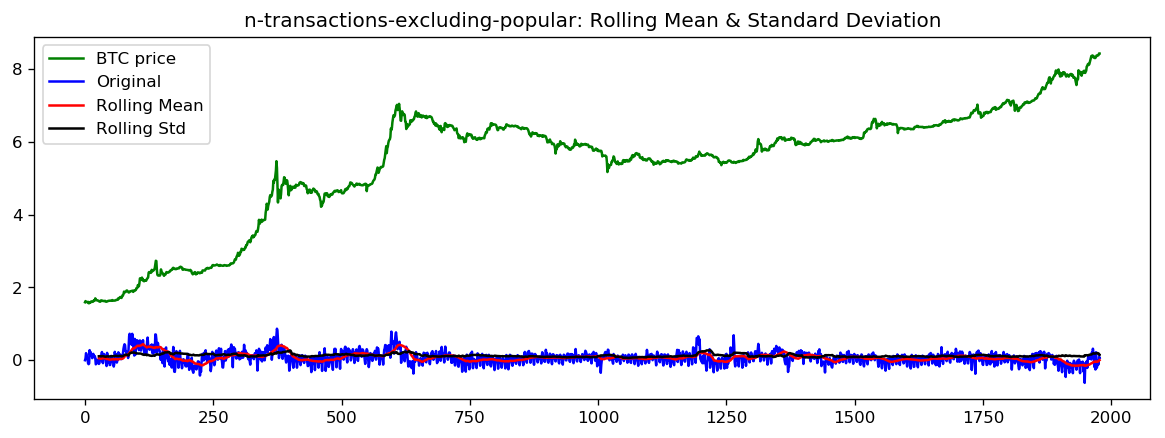

Results of Dickey-Fuller Test:
Test Statistic                   -5.535887
p-value                           0.000002
#Lags Used                       26.000000
Number of Observations Used    1951.000000
Critical Value (1%)              -3.433706
Critical Value (5%)              -2.863023
Critical Value (10%)             -2.567559
dtype: float64





In [18]:
# TRANSFORM ALL FEATURES

transformed_features = []

for f in feature_dict:
    print(feature_dict[f])
    series = features[f]
    newseries = transform_series_log_expweighted(series)
    transformed_features.append(newseries)
    try:
        test_stationarity(newseries,  feature_dict[f], True)
    except:
        print("could nt do")
    print('\n\n')
    

In [19]:
# CREATE TRANSFORMED DATA FRAME

transformed_df = pd.DataFrame(transformed_features[0])
transformed_df.columns = [feature_dict[0]]

for i in feature_dict:
    if i == 0: continue
    new_df = pd.DataFrame(transformed_features[i])
    new_df.columns = [feature_dict[i]]
    transformed_df = pd.concat([transformed_df, new_df], axis=1, join_axes=[transformed_df.index])

new_df = pd.DataFrame(data_df['y'].values)
new_df.columns = ['y']
transformed_df = pd.concat([transformed_df, new_df], axis=1, join_axes=[transformed_df.index])
    
NaN_by_column = transformed_df.isnull().sum(axis=0).tolist()
print(NaN_by_column) # just check there are no NaN elements

print(data_df.shape)
print(transformed_df.shape)
transformed_df.tail()

[0, 0, 0, 0, 0, 0, 0, 0, 0]
(1978, 9)
(1978, 9)


,market-price,trade-volume,median-confirmation-time,hash-rate,transaction-fees-usd,n-unique-addresses,n-transactions,n-transactions-excluding-popular,y
1973,0.406431,-0.256472,0.491514,-0.195362,0.957071,-0.062769,-0.094847,-0.096453,0.0
1974,0.395103,-0.457803,-0.121219,0.189356,0.766494,0.010928,0.049170,-0.009280,1.0
1975,0.393779,0.159194,-0.125324,0.005603,0.807286,0.001589,-0.105491,-0.113564,1.0
1976,0.431055,0.558758,0.239607,0.146076,1.029249,0.159504,0.119654,0.091461,0.0
1977,0.417759,0.108763,-0.098421,0.259587,0.832792,0.109784,0.082652,0.065750,1.0


In [20]:
# SAVE THE TRANSFORMED DATAFRAME TO A CSV FILE
transformed_df.to_csv('transformed_df.csv')

todos:
 - look at data transformation for each feature separately